# Wine Recommendation Engine

by: Zachary Greenberg

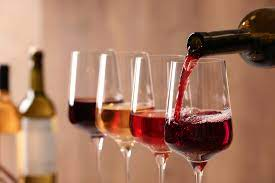

# Overview

The wine industry is gigantic. With extraordinarily large productions of wine comes so many choices. Utilizing Data Science, I intend to give personalized recommendations for wine selection. First, using the provided type of wine as a classifier, I will assess the accuracy of the provided textual reviews in predicting the wine. From here, I will utilize techniques including TF-IDF to vectorize the text and find recommendations based on cosine similarity and euclidean distances.

# Business Understanding

There are so many wines available, so how do you choose? Identifying new wines that are similar to the ones people enjoy can educate them on new bottles and wineries, allowing them to make more informed decisions when choosing their next bottle. Infact, with a roster of wines from a single winery, these companies could use this to recommend their other products.

# Data Understanding

The dataset was scraped from [Vivino.com](www.vivino.com). It contains mostly textual data, but some of the data is numeric. Each row is specific to a bottle of wine. It contains the following information:

-*winery*: str, the winery that makes that specific wine  
-*wine_name*: str, the name of the wine  
-*wine_type*: str, the classification of the wine (ie red, white)  
-*wine_country*: str, the country in which the wine was made  
-*average_rating*: float, the average rating of the wine on Vivino.com  
-*num_of_ratings*: int, the number of ratings for that wine on Vivino.com  
-*wine_price*: float, the price per bottle  
-*grapes*: str, the grapes utilized in the wine  
-*alcohol_content*: the percent alcohol in the wines  
-*reviews*: str, top 3 most helpful text reviews of the wine

In [1]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

In [2]:
#bringing in the dataframe
df = pd.read_csv('Data/wine_data.csv')

In [3]:
#checking the first 5 rows of the DataFrame
df.head()

,winery,wine_name,wine_type,wine_country,average_rating,num_of_ratings,wine_price,grapes,alcohol_content,reviews
0,Abbazia di Novacella (Stiftskellerei Neustift),Praepositus Kerner 2018,White wine,Italy,4.2,404,31.99,100% Kerner,14.5,"4,2 - Vivino’s rating is also mine. This is a ..."
1,Purulio,Blanco 2016,White wine,Spain,4.2,65,18.00,100% Tempranillo,NaN,A great Orange wine from Andalusia made from 9...
2,Croft,Reserve Tawny Porto N.V.,Fortified Wine,Portugal,4.0,813,19.37,"Tinta Amarela, Tinta Cão, Touriga Nacional, Ti...",NaN,Very good reserve tawny port almost pink in co...
3,Venge Vineyards,Scout's Honor Red 2019,Red wine,United States,4.4,29,35.69,Cabernet Sauvignon,NaN,Just opened the well anticipated delivery! Dar...
4,Smith Woodhouse,10 Year Old Tawny Porto N.V.,Fortified Wine,Portugal,3.8,834,38.00,"Tinta Cão, Touriga Nacional, Tinta Roriz",NaN,My first tawny port! Sweet taste of (sultan) r...


In [4]:
#This is the current size of the dataframe
df.shape

(1200, 10)

In [5]:
#checking for duplicates
sum(df.duplicated())

2

In [6]:
#dropping duplicates
df.drop_duplicates(inplace = True)

In [7]:
#checking the dtypes
df.dtypes

winery              object
wine_name           object
wine_type           object
wine_country        object
average_rating     float64
num_of_ratings       int64
wine_price         float64
grapes              object
alcohol_content    float64
reviews             object
dtype: object

The data are of the correct dtypes.

In [8]:
df.describe()

,average_rating,num_of_ratings,wine_price,alcohol_content
count,1198.000000,1198.000000,1091.000000,281.000000
mean,4.116027,738.483306,26.347938,13.116370
std,0.176885,1784.670618,9.530012,2.909249
min,3.000000,25.000000,9.950000,4.500000
25%,4.000000,61.000000,18.990000,12.500000
50%,4.100000,166.500000,25.990000,13.500000
75%,4.200000,533.000000,32.970000,14.500000
max,4.600000,27106.000000,96.890000,20.500000


Based on these summary statistics, these are my observations:
- Being that ratings are on a scale of 1-5, the average rating is quite high.  
- The range of prices for wines is from 9USD  to 96USD.  
- There seems to be a lot of missing values with alcohol_content. Not all of the entries on Vivino.com had this information readily available.

# Data Cleaning

In [9]:
#combining the winery and wine_name to get the full name of the product, the combination named 'title', and then 
#assigning it to the index
df['title'] = df['winery'].str.cat(df['wine_name'], sep = ' ')
df.set_index('title', inplace = True)

In [10]:
#creating a function to remove the year from the 'wine' column
def remove_year_in_name(x):
    '''
    This function removes the year from the 
    wine (name of wine) column.
    '''
    if '18' or '19' or '20' in x:
        x = x[:-5]
        return x
    else:
        return x

I have decided to remove the year from the 'wine_name' column for easier filtering. The year will still be a part of the full 'title' variable that is now the index of the dataset. 

In [11]:
#applying the function above
df['wine_name'] = df['wine_name'].apply(remove_year_in_name)

In [12]:
df.isnull().sum()

winery               0
wine_name            0
wine_type            0
wine_country         1
average_rating       0
num_of_ratings       0
wine_price         107
grapes             307
alcohol_content    917
reviews            266
dtype: int64

This verifies that a little more than half of the entries for alcohol_content are not available. Perhaps the column should be dropped. Wine price, I believe is something that can be imputed, as for the reviews, I would not suggest any filling techniques for the null values. For grapes, some of the information can be filled in as the grape name is often a part of the wine name.

In [13]:
#dropping the alcohol column
df.drop('alcohol_content', axis = 1, inplace = True)

With some of the price variables missing, I am going to impute them with the mean.

In [14]:
#imputing the mean
wine_mean = df.wine_price.mean()

df['wine_price'].fillna(wine_mean, inplace = True)

Below I will remove the null review entries.

In [15]:
#dropping the rows with the missing reviews
df.dropna(subset = ['reviews'], inplace = True)

In [16]:
#creating a function to fix a capitalization error
def lowercase_W(x):
    """
    This function changes the capitalization error
    in Fortified Wine
    """
    if x == 'Fortified Wine':
        x = 'Fortified wine'
        return x
    else:
        return x

In [17]:
df['wine_type'] = df['wine_type'].apply(lowercase_W)

In [18]:
#changing the wine_type to a single word
conditions = [df['wine_type'] == 'White wine',df['wine_type'] == 'Red wine',
               df['wine_type'] =='Sparkling wine',df['wine_type'] == 'Rosé wine', 
               df['wine_type'] =='Dessert wine', df['wine_type'] =='Fortified wine']
choices = ['White', 'Red', 'Sparkling', 'Rosé', 'Dessert', 'Fortified']

df['wine_type'] = np.select(conditions, choices)

In [19]:
#creating a function to clean the grape column
def clean_grape_column(x):
    '''
    This function cleans the entries in the grape
    column to make all grapes have 
    only 1 name. It removes the '100 %', and it
    also makes any 2 or more grapes in 1 wine 
    as a blend.
    '''
    if type(x) == float: #this will keep the NaN values in tact
        return x
    if ',' in x:
        return 'Blend'
    elif '%' in x:
        return ' '.join(x.split()[1:])
    else:
        return x
    

In [20]:
df['grapes'] = df['grapes'].apply(clean_grape_column)

In [21]:
df[df['grapes'].isna()].head(2)

,winery,wine_name,wine_type,wine_country,average_rating,num_of_ratings,wine_price,grapes,reviews
title,,,,,,,,,
Primitivo Quiles Raspay Riserva 2008,Primitivo Quiles,Raspay Riserva,Sparkling,Spain,4.1,84,19.95,NaN,"Firm black cherry on the nose, beautiful deep ..."
AIX Rosé 2020,AIX,Rosé,Rosé,France,4.1,222,18.35,NaN,8.2/10 Another good example of rose wine. Fres...


I was hoping that for these NaN values that the name of the grape would be in the wine_name column as they typically would be a part of the name of the wine. Because they are not for these remainder grapes, I will have to drop these rows. 

In [22]:
df.dropna(subset=['grapes'], inplace = True)

Now that I have categorized 2 or more grapes as a blend, I can get a little more specific in terms of the type of blend based on the type of wine:

In [23]:
#changing the Blend to Red, White Blend etc...
types = df['wine_type'].tolist()
grapes = df['grapes'].tolist()

for i, n in enumerate(grapes):
    if grapes[i] == 'Blend':
        grapes[i] = types[i] + ' ' + 'Blend'
        
df['grapes'] = grapes

In [24]:
df.shape

(885, 9)

This dataset now has 885 wines.

# Exploratory Data Analysis

In [25]:
#looking at unique wineries
df['winery'].nunique()

632

In [26]:
#looking at the wines by winery
df.groupby('winery')['wine_name'].count().sort_values(ascending = False).head()

winery
Lustau             9
Bartenura          8
Sandeman           7
Gérard Bertrand    7
Kracher            7
Name: wine_name, dtype: int64

It seems the Lustau winery has 9 different products represented in this dataset. I will use that later on and create a version of a recommender based on winery.

In [27]:
#looking at the distributon of wine types
df['wine_type'].value_counts()

White        172
Rosé         156
Sparkling    153
Red          147
Dessert      147
Fortified    110
Name: wine_type, dtype: int64

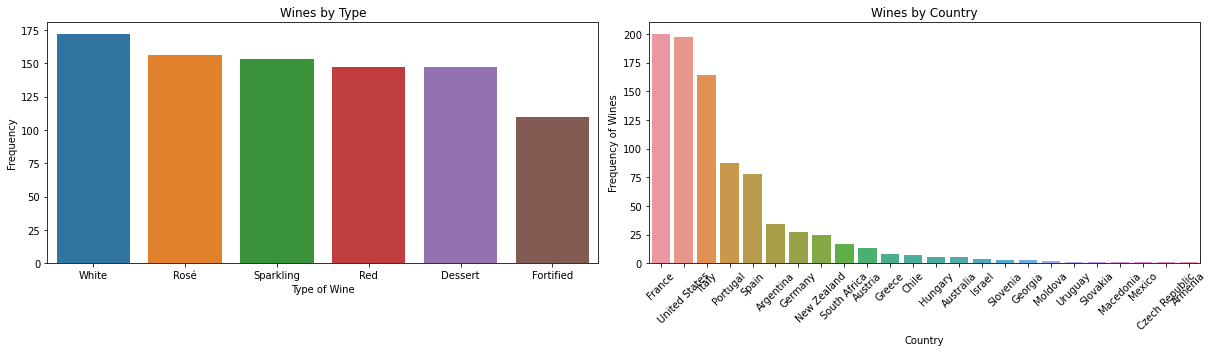

In [28]:
#graphing the distribution of wines by type and country
fig, axes = plt.subplots(1, 2, figsize=(17, 5))

one = sns.barplot(ax=axes[0], x=df['wine_type'].value_counts().index, y=df['wine_type'].value_counts().values)
axes[0].set_title('Wines by Type')
axes[0].set_xlabel('Type of Wine')
axes[0].set_ylabel('Frequency')

two = sns.barplot(ax=axes[1], x=df['wine_country'].value_counts().index, y=df['wine_country'].value_counts().values)
two.set_xticklabels(df['wine_country'].value_counts().index, rotation = 45)
axes[1].set_title('Wines by Country')
axes[1].set_xlabel('Country')
axes[1].set_ylabel('Frequency of Wines')

plt.tight_layout()
plt.savefig('Images/wine_graphs.png');

There seems to be a fairly even distribution of wines in the dataset. Some of the entries for Fortified were filtered out due to their lack of information provided by Vivino.com. The majority of the wines in this dataset come from France, the United States and Italy. I did not find this surprising at all. 

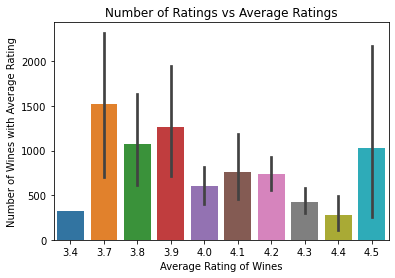

In [29]:
#graphing the ratings data
fig, ax = plt.subplots()
sns.barplot(df['average_rating'], df['num_of_ratings'])
ax.set_xlabel('Average Rating of Wines')
ax.set_ylabel('Number of Wines with Average Rating')
ax.set_title('Number of Ratings vs Average Ratings');

Although the ratings are from 1 - 5, the range of ratings in this dataset are barely larger than 1.0. This means most of the wines have a fairly similar rating. The mode of the ratings collected is the 3.7 mark. This is representative of truly average thoughts about the wine. 

In [30]:
df.grapes.value_counts().head()

Rosé Blend         76
Chardonnay         59
Sauvignon Blanc    58
Pinot Noir         55
Fortified Blend    54
Name: grapes, dtype: int64

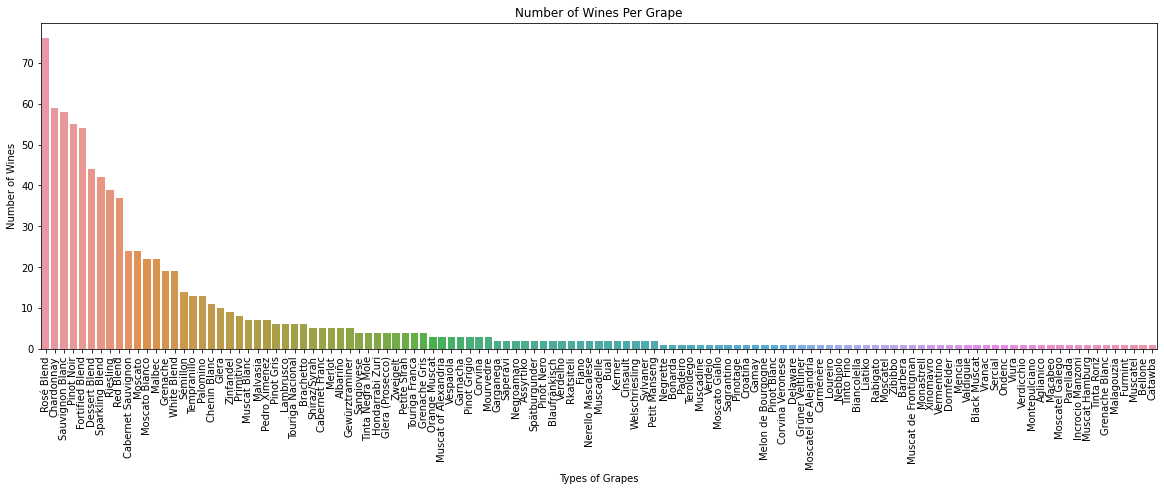

In [31]:
#graphing the number of wines per grape
fig, ax = plt.subplots(figsize=(20,6))
sns.barplot(df['grapes'].value_counts().index, df['grapes'].value_counts().values)
ax.set_xlabel('Types of Grapes')
ax.set_ylabel('Number of Wines')
ax.set_xticklabels(df['grapes'].value_counts().index, rotation = 90)
ax.set_title('Number of Wines Per Grape');

Most of the wines in this dataset are Rosé blends. Infact, I would say that blends make up the majority of wines in the dataset. This shows that the combination of grapes in a wine is a popular technique. 

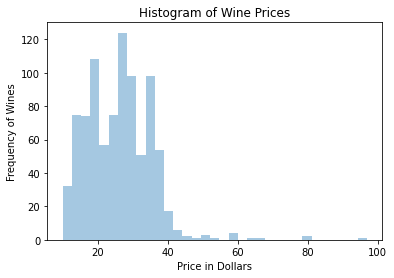

In [32]:
#graphing a histogram of wine prices
fig, ax = plt.subplots()
sns.distplot(df['wine_price'], kde = False)
ax.set_title('Histogram of Wine Prices')
ax.set_xlabel('Price in Dollars')
ax.set_ylabel('Frequency of Wines');

The majority of the wines prices seem to fall around the 25-30 USD mark. The range of the wines is quite large, giving room for suggestion based on price as a possibility for another variation of a recommendation engine. 

In [33]:
df.groupby('wine_type')['wine_price'].mean().index

Index(['Dessert', 'Fortified', 'Red', 'Rosé', 'Sparkling', 'White'], dtype='object', name='wine_type')

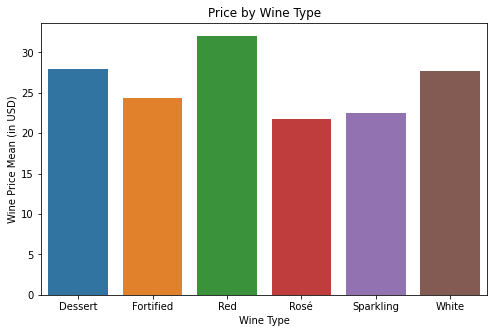

In [34]:
#graphing the price by wine type
fig, ax = plt.subplots(figsize=(8, 5))
sns.barplot(df.groupby('wine_type')['wine_price'].mean().index, df.groupby('wine_type')['wine_price'].mean().values)
ax.set_xlabel('Wine Type')
ax.set_ylabel('Wine Price Mean (in USD)')
ax.set_title('Price by Wine Type');

It seems that red wine tends to be a bit pricer than others, however, in the scope of things, the difference in average price between the types of wine is not much. This means that if a person were to favor a specific wine type it would not cost them too much more for their preference.

# Data Preprocessing

## Natural Language Processing

Now that I understand the data better, I can move on to preprocessing the text reviews using NLP. In this step, I will be adding the grapes and wine types into the stopwords as well so that I can do a Classification algorithm on them below.

In [35]:
#importing NLP libraries
from nltk.corpus import stopwords
from nltk import pos_tag
import re
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

In [36]:
#generating the list of NLTK's typical english stop words
sw = stopwords.words('english') 

#this is a list of grapes lowercased to add to stopwords
wine_string = ','.join(list(df['grapes'].str.lower().unique()))
if ' ' in wine_string:
    wine_string = wine_string.replace(' ', ',')

grape_sw = wine_string.split(',')

#compiling a list of wine_types to add to stop words as well
kind_sw = []

for kind in list(df['wine_type'].unique()):
    kind = kind.lower().replace(' wine', '')
    kind_sw.append(kind)


#adding the grape & kind stop words to the list of all stop words
sw.extend(grape_sw)
sw.extend(kind_sw)

#adding additional words in as well that are unnecessary:
unnecessary_words = ['port', 'good', 'nice', 'smell', 'taste', 'mouth', 
                     'nose', 'great', 'note', 'finish', 'tannin', 
                     'wine', 'like', 'palate', 'aroma', 'one', 'hint',
                    'well', 'long', 'short', 'ro', 'flavor', 'lovely', 'really', 
                     'very', 'bit', 'little', 'make', 'open', 'lot']
sw.extend(unnecessary_words)

In [37]:
def get_wordnet_pos(treebank_tag):
    '''
    This function will convert nltk POS 
    to wordnet tags
    '''
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [38]:
def text_preparer(doc, stopwords=sw):
    '''
    This function takes in a document, and a list of
    stop words. It prepares the text by removing the numbers
    and punctuation (with Regex), lowercasing the 
    elements, and lemmatizing the text.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)")
    doc = regex_token.tokenize(doc)
    doc = [word.lower() for word in doc]
    doc = [word for word in doc if word not in sw]
    doc = pos_tag(doc)
    #The lemmatizer wants to know what to look for:
    doc = [(word[0], get_wordnet_pos(word[1])) for word in doc]
    lemmatizer = WordNetLemmatizer() 
    doc = [lemmatizer.lemmatize(word[0], word[1]) for word in doc]
    return ' '.join(doc)

In [39]:
#parsing the review text 
df['token_reviews'] = df['reviews'].apply(text_preparer)

In [40]:
#getting the groups together to make word clouds
White = df[df['wine_type'] == 'White']['token_reviews'].values.tolist()
Red = df[df['wine_type'] == 'Red']['token_reviews'].values.tolist()
Sparkling = df[df['wine_type'] == 'Sparkling']['token_reviews'].values.tolist()
Fortified = df[df['wine_type'] == 'Fortified']['token_reviews'].values.tolist()
Dessert = df[df['wine_type'] == 'Dessert']['token_reviews'].values.tolist()
Rosé = df[df['wine_type'] == 'Rosé']['token_reviews'].values.tolist()
texts = [White, Red, Sparkling, Fortified, Dessert, Rosé]

#these will be the labels for word clouds
labels = ['White', 'Red', 'Sparkling', 'Fortified', 'Dessert', 'Rosé']

In [41]:
from wordcloud import WordCloud

def show_wordcloud(data, labels):
    """
    This function takes a list of text data variables
    (the data itself must also being in list form) 
    and it also takes a list of labels and returns 
    a word cloud.
    """
    i = 0
    for group in data:
        wordcloud = WordCloud(
            background_color='black',
            stopwords=sw,
            max_words=30, 
            scale=3,
            random_state=12
        ).generate(str(group))

        fig = plt.figure(1, figsize=(6, 6))
        plt.axis('off')
        plt.title(labels[i])
        plt.imshow(wordcloud)
        plt.tight_layout(pad=0)
        #This saves each figure individually!
        plt.savefig(f'Images/{labels[i]}Cloud.png', transparent = True) 
        plt.show()
        i+=1

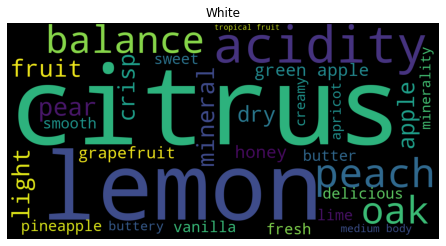

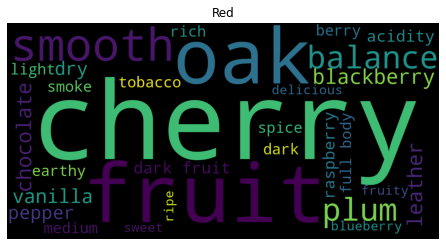

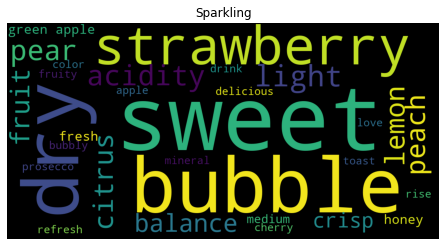

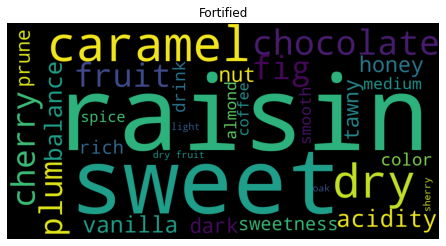

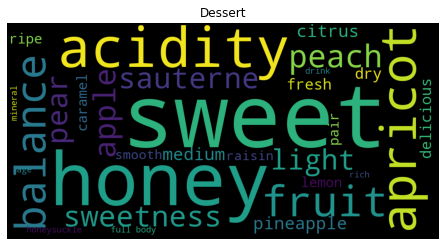

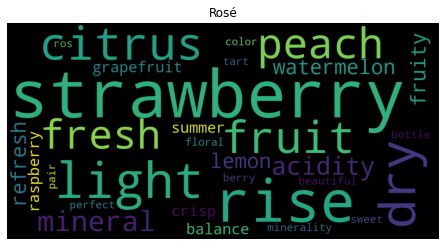

In [42]:
#generating word clouds for each of the wine types
show_wordcloud(texts, labels)

With some domain knowledge of the conventional descriptions of these wine types, I would say that these reviews seem to do a good job at face value.

## Vectorization & Standardization

Before I do some modeling, I will use TFIDF to vectorize my text reviews, merge the array to the DataFrame, and scale:

In [43]:
#getting dummy columns for the categorical variables
dummy_columns = ['wine_country', 'grapes']

df_model = pd.get_dummies(df, columns = dummy_columns)

In [44]:
#vectorizing text reviews
from sklearn.feature_extraction.text import TfidfVectorizer

tfidfvec = TfidfVectorizer(tokenizer = text_preparer)
tf_idfwine = tfidfvec.fit_transform((df_model['token_reviews']))

In [45]:
df_tfidf = pd.DataFrame(tf_idfwine.toarray())

In [46]:
#dropping unnecessary columns from the df_model DataFrame
model_data = df_model.drop(labels = ['winery', 'wine_name', 'wine_type', 'reviews', 'token_reviews'], axis = 1)
model_data = pd.concat([model_data.reset_index(), df_tfidf], axis = 1)
model_data.set_index('title', inplace = True)

In [47]:
model_data.columns[:3] #aside from the dummy variables and vectorized columns, these are the other ones in the model

Index(['average_rating', 'num_of_ratings', 'wine_price'], dtype='object')

In [48]:
#scaling the new matrix
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(model_data)

scale_model_data = pd.DataFrame(scaler.transform(model_data), columns = model_data.columns, index = model_data.index)

# Modeling

## Classification

As a form of supervised learning, and a clarity check, I am going to perform some Classification algorithms on the text reviews and assess their accuracy on identifying the type of wine in the 'wine_types' column.

### Random Forest 

In [49]:
from sklearn.model_selection import train_test_split

In [50]:
X = df['reviews']
y = df['wine_type']

In [51]:
#splitting the data
X_train, X_test, y_train, y_test =  train_test_split(X, y, train_size= .8, random_state= 13)

In [52]:
#creating a RandomForest pipeline with a grid search
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
accuracy = make_scorer(accuracy_score)

pipeline = Pipeline([
                    ('tv', TfidfVectorizer()),
                    ('rf', RandomForestClassifier(random_state=42))
                    ])


rf_param_grid_pipe = {
    "rf__criterion": ["gini", "entropy"],
    "rf__max_depth": [None, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16],
    "rf__max_features": [None,4,5,6,9,10],
    "rf__min_samples_split": [2, 5, 10],
    "rf__min_samples_leaf" : [1, 2, 3, 5, 6],
    "rf__n_estimators" : [10, 30, 100]
}


grid_search_pipe = GridSearchCV(pipeline, rf_param_grid_pipe, cv=3, verbose=1, n_jobs=-1, scoring = accuracy)

grid_search_pipe.fit(X_train, y_train)

Fitting 3 folds for each of 5940 candidates, totalling 17820 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   34.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   53.9s
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed:  8.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tv', TfidfVectorizer()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__criterion': ['gini', 'entropy'],
                         'rf__max_depth': [None, 2, 3, 4, 5, 6, 8, 10, 12, 14,
                                           16],
                         'rf__max_features': [None, 4, 5, 6, 9, 10],
                         'rf__min_samples_leaf': [1, 2, 3, 5, 6],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [10, 30, 100]},
             scoring=make_scorer(accuracy_score), verbose=1)

In [53]:
print(grid_search_pipe.best_params_)

{'rf__criterion': 'gini', 'rf__max_depth': None, 'rf__max_features': 9, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}


In [54]:
grid_search_pipe.score(X_test, y_test)

0.7627118644067796

76% accuracy is not too terrible. I would be curious to see if a MultiNomial Naive Bayes model would have better accuracy performance. 

### MultiNomial Bayes

In [55]:
from sklearn.naive_bayes import MultinomialNB

mb = Pipeline([
                    ('tv', TfidfVectorizer()),
                    ('mb', MultinomialNB())
                    ])

param_grid_pipe = {
    "mb__alpha": [1, .5, .25, .75],
    
}


grid_search_pipe = GridSearchCV(mb, param_grid_pipe, cv=3, verbose=1, n_jobs=-1, scoring=accuracy)
grid_search_pipe.fit(X_train, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  12 | elapsed:    0.3s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed:    0.3s finished


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('tv', TfidfVectorizer()),
                                       ('mb', MultinomialNB())]),
             n_jobs=-1, param_grid={'mb__alpha': [1, 0.5, 0.25, 0.75]},
             scoring=make_scorer(accuracy_score), verbose=1)

In [56]:
print(grid_search_pipe.best_params_)

{'mb__alpha': 0.25}


In [57]:
grid_search_pipe.score(X_test, y_test)

0.8022598870056498

When comparing the two algorithms, the Multinomial Bayes gave a higher accuracy score. I will now run a model with those parameters to look at the confusion matrix.

In [58]:
mb = Pipeline([
                    ('tv', TfidfVectorizer()),
                    ('mb', MultinomialNB(alpha = .25))
                    ])

mb.fit(X_train, y_train)

Pipeline(steps=[('tv', TfidfVectorizer()), ('mb', MultinomialNB(alpha=0.25))])

In [59]:
y_pred_mb = mb.predict(X_test)

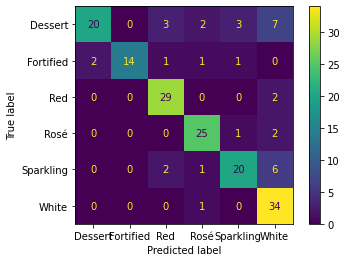

In [60]:
from sklearn.metrics import plot_confusion_matrix, classification_report
plot_confusion_matrix(mb,y_pred_mb, y_test)
plt.savefig('Images/Matrix.png');

The dessert wine category seemed to perform the worst out of all them. I believe this is due to the broadness of the category itself. The other categories seem to be more specifically defined.

In [61]:
from sklearn.metrics import plot_confusion_matrix, classification_report
print(classification_report(y_test, y_pred_mb))

              precision    recall  f1-score   support

     Dessert       0.91      0.57      0.70        35
   Fortified       1.00      0.74      0.85        19
         Red       0.83      0.94      0.88        31
        Rosé       0.83      0.89      0.86        28
   Sparkling       0.80      0.69      0.74        29
       White       0.67      0.97      0.79        35

    accuracy                           0.80       177
   macro avg       0.84      0.80      0.80       177
weighted avg       0.83      0.80      0.80       177



The reviews show an 80% accuracy of identifying the types of wine. This shows that the reviews can be helpful in making recommendations. 

## Recommender Systems

### By Title (Wine Full Name)

#### Cosine Similarity Model

In [62]:
from sklearn.metrics.pairwise import cosine_similarity

#calculating the cosine similarities of the model on itself.
cos_sim = cosine_similarity(scale_model_data, scale_model_data)

In [63]:
# Storing indices of the data
indices = pd.Series(df.index)
  
def cosine_recommendations(wine, cos_sim, num_recommendations):
    """
    This function takes in a wine from the index along 
    with the cosine distance array, and number of recommendations. 
    It returns the top wines recommended with the highest similarity
    scores.
    """
    recommended_wines = []
    index = indices[indices == wine].index[0]
    similarity_scores = pd.Series(cos_sim[index]).sort_values(ascending = False)
    top_recommended_wines = list(similarity_scores.iloc[1:num_recommendations+1].index)
    for i in top_recommended_wines:
        recommended_wines.append(list(df_model.index)[i])
        matches = df.loc[recommended_wines][['wine_type', 'wine_country', 'average_rating', 'wine_price']]
    matches['similarity_scores'] = list(similarity_scores.iloc[1:num_recommendations+1].values)
    return matches
        

In [64]:
print('Cosine Similarity Model by Title')
domaine_cosine = cosine_recommendations("Domaine du Salvard Cheverny Rosé 2016", cos_sim, 10)
domaine_cosine

Cosine Similarity Model by Title


,wine_type,wine_country,average_rating,wine_price,similarity_scores
title,,,,,
Jean-Luc Colombo Cape Bleue Rosé 2019,Rosé,France,3.9,13.24,0.787662
Château d'Esclans The Palm Whispering Angel Rosé 2019,Rosé,France,3.9,15.99,0.696514
Domaine Le Galantin Bandol Rosé 2019,Rosé,France,4.1,21.95,0.690920
Château Castel des Maures Cuvée Jeanne Côtes de Provence Rosé 2019,Rosé,France,3.9,24.99,0.685842
Domaine de la Mordorée La Reine des Bois Tavel Rosé 2018,Rosé,France,4.0,29.99,0.664170
Château d'Esclans The Palm Whispering Angel Rosé 2018,Rosé,France,3.9,18.99,0.664047
Commanderie de la Bargemone Rosé 2019,Rosé,France,4.1,16.99,0.652490
Château de Berne Château de Berne Rosé 2018,Rosé,France,3.9,18.99,0.646333
Domaines Bunan Mas de la Rouvière Rosé 2019,Rosé,France,4.0,27.99,0.634996


Using Cosine Similarity as a metric, these are the top 10 wines that are similar to the 'Domaine du Salvard Cheverny Rosé 2016' wine I have set as a parameter to the function. This seems logical because the original wine, is also a Rosé wine from France. 

#### Euclidean Distance

In [65]:
from sklearn.metrics.pairwise import euclidean_distances

euc_dist = euclidean_distances(scale_model_data, scale_model_data)

In [66]:
# Storing indices of the data
indices = pd.Series(df.index)
  
def euclidean_recommendations(wine, euc_dist, num_recommendations):
    """
    This function takes in a wine from the index along 
    with the euclidean distance array, and number of
    recommendations. It returns the top recommended wines
    with the highest similarity scores.
    """
    recommended_wines = []
    index = indices[indices == wine].index[0]
    similarity_scores = pd.Series(euc_dist[index]).sort_values(ascending = True)
    top_10_wines = list(similarity_scores.iloc[1:num_recommendations+1].index)
    for i in top_10_wines:
        recommended_wines.append(list(df_model.index)[i])
        matches = df.loc[recommended_wines][['wine_type', 'wine_country', 'average_rating', 'wine_price']]
    matches['similarity_scores'] = list(similarity_scores.iloc[1:num_recommendations+1].values)
    return matches
        

In [67]:
print('Euclidean Distance Model')
domaine_euclidean = euclidean_recommendations("Domaine du Salvard Cheverny Rosé 2016", euc_dist, 10)
domaine_euclidean

Euclidean Distance Model


,wine_type,wine_country,average_rating,wine_price,similarity_scores
title,,,,,
Jean-Luc Colombo Cape Bleue Rosé 2019,Rosé,France,3.9,13.24,3.991228
Domaine Le Galantin Bandol Rosé 2019,Rosé,France,4.1,21.95,4.579773
Château d'Esclans The Palm Whispering Angel Rosé 2019,Rosé,France,3.9,15.99,4.630614
Domaine de la Mordorée La Reine des Bois Tavel Rosé 2018,Rosé,France,4.0,29.99,4.685385
Château Castel des Maures Cuvée Jeanne Côtes de Provence Rosé 2019,Rosé,France,3.9,24.99,4.804113
Château de Berne Château de Berne Rosé 2018,Rosé,France,3.9,18.99,4.905444
Domaines Bunan Mas de la Rouvière Rosé 2019,Rosé,France,4.0,27.99,4.925175
Commanderie de la Bargemone Rosé 2019,Rosé,France,4.1,16.99,4.959448
Âme du Vin Côtes de Provence Rosé 2019,Rosé,France,4.0,15.98,5.112811


This time, using Euclidean Distance as a metric, these are the top 10 wines recommended for that same bottle. Again, it seems logical so far because all of these wines are Rosé and from France like the original one in the input. 

In order to compare the two methods together, I think I will have to check the wine_price variable. This would probably give a better sense of which method yielded the best results.

In [68]:
#creating a dataframe to get a closer look at the other variables.
pd.DataFrame({'Domaine du Salvard Cheverny Rosé 2016': [df.loc['Domaine du Salvard Cheverny Rosé 2016']['average_rating'], df.loc['Domaine du Salvard Cheverny Rosé 2016']['wine_price']],
             'Cosine Average': [domaine_cosine['average_rating'].mean(), domaine_cosine['wine_price'].mean()], 
             'Euclidean Average': [domaine_euclidean['average_rating'].mean(), domaine_euclidean['wine_price'].mean()]}, index = ['Average Rating', 'Wine Price'])

,Domaine du Salvard Cheverny Rosé 2016,Cosine Average,Euclidean Average
Average Rating,4.00,3.980,3.97
Wine Price,9.95,20.696,20.51


Taking a closer look at the other two variables, rating and price, it is a close call. Euclidean Average Price seems to be a little bit closer to the wine price of the Domaine du Salvard. Additionally, the rating from the cosine model is closer to the Domaine. 

### By Winery

#### Cosine Similarity

In this dataset, there were 9 wines produced by a single winery. I would be curious to see the recommendations based on a single winery. Due to the small roster, I will generate a model to give the top 5 recommendations from a single winery

In [69]:
df[df['winery'] == 'Lustau'].head(2)

,winery,wine_name,wine_type,wine_country,average_rating,num_of_ratings,wine_price,grapes,reviews,token_reviews
title,,,,,,,,,,
Lustau East India Solera Sherry N.V.,Lustau,East India Solera Sherry,Fortified,Spain,4.0,2423,22.99,Pedro Ximenez,FOC Dinner w/Sherry pairing (#4/4) Had this sw...,foc dinner w sherry pair sweet style sherry th...
Lustau Capataz Andrés Deluxe Cream Sherry (Solera Reserva) N.V.,Lustau,Capataz Andrés Deluxe Cream Sherry (Solera Res...,Fortified,Spain,3.8,575,18.00,Pedro Ximenez,20%. Deep red brown. Blend of Palomino and Ped...,deep brown grape ripe fruit raisin figs easy d...


In [70]:
lustau = df[df['winery'] == 'Lustau']

print('Cosine Similarity Model by Winery')
lustau_cosine = cosine_recommendations('Lustau San Emilio Pedro Ximenez N.V.', cos_sim, 5)
lustau_cosine

Cosine Similarity Model by Winery


,wine_type,wine_country,average_rating,wine_price,similarity_scores
title,,,,,
Bodegas Yuste Aurora Pedro Ximenez Sherry N.V.,Fortified,Spain,4.0,26.99,0.951112
Osborne Pedro Ximenez 1827 Jerez-Xeres-Sherry N.V.,Fortified,Spain,3.9,17.79,0.909609
Lustau East India Solera Sherry N.V.,Fortified,Spain,4.0,22.99,0.902963
Álvaro Domecq 1730 Pedro Ximenez N.V.,Fortified,Spain,4.4,37.99,0.875215
Lustau Superior Rare Cream Sherry (Reserva Solera) N.V.,Fortified,Spain,4.0,15.99,0.874095


These are the top 5 wines recommended from the Lustau winery after choosing the Lustau San Emilio Pedro Ximenez N.V. as a base for recommendations. They all have particularly high cosine similarity scores which is a great sign of relativity. 

#### Euclidean Distance

In [71]:
print('Euclidean Distance Model by Winery')
lustau_euclidean = euclidean_recommendations('Lustau San Emilio Pedro Ximenez N.V.', euc_dist, 5)
lustau_euclidean

Euclidean Distance Model by Winery


,wine_type,wine_country,average_rating,wine_price,similarity_scores
title,,,,,
Bodegas Yuste Aurora Pedro Ximenez Sherry N.V.,Fortified,Spain,4.0,26.99,3.880346
Osborne Pedro Ximenez 1827 Jerez-Xeres-Sherry N.V.,Fortified,Spain,3.9,17.79,5.261519
Lustau East India Solera Sherry N.V.,Fortified,Spain,4.0,22.99,5.469537
Lustau Superior Rare Cream Sherry (Reserva Solera) N.V.,Fortified,Spain,4.0,15.99,6.298066
Álvaro Domecq 1730 Pedro Ximenez N.V.,Fortified,Spain,4.4,37.99,6.382290


These are the top 5 recommendations from the Lustau winery using Euclidean Distance. 

To decide the best model, I would like to again take a closer look at the average_rating and wine_price variables from both models for comparison. 

In [72]:
#creating a dataframe to get a closer look at the other variables.
pd.DataFrame({'Lustau San Emilio Pedro Ximenez N.V.': [df.loc['Lustau San Emilio Pedro Ximenez N.V.']['average_rating'], df.loc['Lustau San Emilio Pedro Ximenez N.V.']['wine_price']],
             'Cosine Average': [lustau_cosine['average_rating'].mean(), lustau_cosine['wine_price'].mean()], 
             'Euclidean Average': [lustau_euclidean['average_rating'].mean(), lustau_euclidean['wine_price'].mean()]}, index = ['Average Rating', 'Wine Price'])

,Lustau San Emilio Pedro Ximenez N.V.,Cosine Average,Euclidean Average
Average Rating,4.10,4.06,4.06
Wine Price,37.99,24.35,24.35


Taking a closer look here, both of the models have identical scores as they have returned the exact same wines, but in a slightly different order.

# Evaluation

The results of my content based recommendation systems, created using the cosine similarity and euclidean distancing metrics, are difficult to interpret by the numbers as they are either exactly the same or balance out in their differences when comparing the price and rating. For both title and winery models and their variations, I would say that the best results may have to be based on opinion. On that note of opinion, I had a couple of my friends, who are avid wine drinkers, test the models and they did feel that the output of the Euclidean distance on both models seemed a bit more logical based on the order of their recommendations. I am assured on the recommendation system as a whole, having performed classification algorithms on the review text, and achieving the accuracy results I did. 